# Import

In [1]:
import copy
import argparse
import datetime
import os
import sys
import traceback
import matplotlib.pyplot as plt

import numpy as np
import healpy as hp
from astropy import units as u

# Import sotodlib.toast first, since that sets default object names
# to use in toast.
import sotodlib.toast as sotoast

import toast
import toast.ops

from toast.mpi import MPI, Comm

from toast import spt3g as t3g

if t3g.available:
    from spt3g import core as c3g

import sotodlib.toast.ops as so_ops
import sotodlib.mapmaking

# Make sure pixell uses a reliable FFT engine
import pixell.fft
pixell.fft.engine = "fftw"

# Load Schedule

In [2]:
schedule = toast.schedule.GroundSchedule()
schedule.read('/homes/tterasaki/workspace/bcp/220910_manual_planet_sim/schedule_Jupiter_oneshot.txt')

TOAST INFO: Loading schedule from /homes/tterasaki/workspace/bcp/220910_manual_planet_sim/schedule_Jupiter_oneshot.txt
TOAST INFO: Loaded 1 scans from /homes/tterasaki/workspace/bcp/220910_manual_planet_sim/schedule_Jupiter_oneshot.txt totaling 46.5 minutes.


# Get SO FocalPlane

In [3]:
# sample_rate = 10. #Hz
# focalplane = sotoast.SOFocalplane(
#         hwfile=None,
#         telescope='SAT1',
#         sample_rate=sample_rate * u.Hz,
#         bands='SAT_f090,SAT_f150',
#         wafer_slots='w25,w26,w27,w28,w29,w30,w31',
#         tube_slots=None,
#         thinfp=None,
#         comm=None,
#     )

sample_rate = 10. #Hz
focalplane = sotoast.SOFocalplane(
        hwfile=None,
        telescope='SAT1',
        sample_rate=sample_rate * u.Hz,
        bands='SAT_f090',
        wafer_slots='w25',
        tube_slots=None,
        thinfp=None,
        comm=None,
    )

TOAST INFO: Simulating default hardware configuration
TOAST INFO: 860 detectors match query: telescope=SAT1, tube_slots=None, wafer_slots=w25, bands=SAT_f090, thinfp=None


# Create Telescope

In [4]:
telescope = toast.Telescope(name="SAT1", focalplane=focalplane, 
                        site=toast.GroundSite("Atacama", schedule.site_lat,
                                                schedule.site_lon, schedule.site_alt))

# Data
Instantiate data object and define some ploting tools.

In [5]:
data = toast.Data()

def plot_one_timestream(data):
    obs = data.obs[0]
    dets = obs.local_detectors

    fig, ax = plt.subplots(1,1,figsize=(3,1))
    ax.plot(obs.shared["times"], obs.detdata["signal"][dets[0]])
    ax.set_xlabel('utc')
    ax.set_ylabel('Kcmb')
    
def decorater_for_comparison(func):
    def plot_before_and_after(*args):
        # get data before apply the function
        #data_before = copy.deepcopy(args[0])
        data_before =args[0]
        obs_before = data_before.obs[0]
        dets_before = obs_before.local_detectors
        time_before = copy.deepcopy(obs_before.shared["times"])
        signal_before = copy.deepcopy(obs_before.detdata["signal"][dets_before[0]])

        # apply the function
        data_after, operator = func(*args)
        obs_after = data_after.obs[0]
        dets_after = obs_after.local_detectors
        time_after = copy.deepcopy(obs_after.shared["times"])
        signal_after = copy.deepcopy(obs_after.detdata["signal"][dets_after[0]])

        # plot before and after (full data length)
        fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(6,2), sharex=True)
        ax[0].plot(time_before, signal_before, label='det[0] (before)', alpha=0.5)
        ax[0].plot(time_after, signal_after, label='det[0] (after)', alpha=0.5)
        ax[0].set_ylabel('signal [Kcmb]')
        ax[0].legend()
        # plot after - before
        ax[1].plot(time_after, signal_after - signal_before,
                   label='det[0] (after - before)')
        ax[1].set_xlabel('utc')
        ax[1].set_ylabel('diff')
        ax[1].legend()
        ax[0].set_title('full length')
        
        # plot before and after (for first 1000 samples) 
        fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(6,2), sharex=True)
        ax[0].plot(time_before[:1000], signal_before[:1000], label='det[0] (before)', alpha=0.5)
        ax[0].plot(time_after[:1000], signal_after[:1000], label='det[0] (after)', alpha=0.5)
        ax[0].set_ylabel('signal [Kcmb]')
        ax[0].legend()
        ax[1].plot(time_after[:1000], signal_after[:1000] - signal_before[:1000],
                   label='det[0] (after - before)')
        ax[1].set_xlabel('utc')
        ax[1].set_ylabel('diff')
        ax[1].legend()
        ax[0].set_title('for first 1000 samples')
        return data_after, operator

    return plot_before_and_after

Text(0, 0.5, 'hwp_angle [rad]')

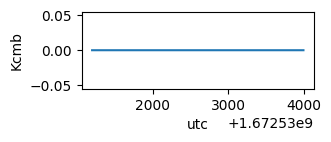

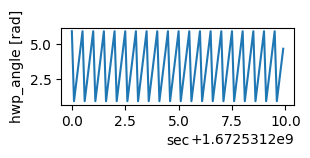

In [6]:
def apply_sim_gnd(data):
    sim_gnd = toast.ops.SimGround(
            telescope=telescope,
            schedule=schedule,
            weather="atacama",
            hwp_angle='hwp_angle',
            hwp_rpm=120,
        )
    sim_gnd.apply(data)
    plot_one_timestream(data)
    return data, sim_gnd

_, sim_gnd = apply_sim_gnd(data)

fig,ax = plt.subplots(1,1,figsize=(3,1))
ax.plot(data.obs[0].shared['times'][:100], data.obs[0].shared['hwp_angle'][:100])
ax.set_xlabel('sec')
ax.set_ylabel('hwp_angle [rad]')

# Pointing

Text(0, 0.5, 'azimuth [deg]')

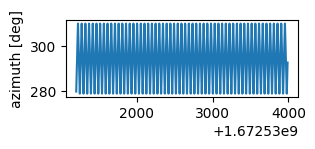

In [8]:

def apply_det_pointing_radec(data):
    det_pointing_radec =toast.ops.PointingDetectorSimple(name='det_pointing_radec', quats='quats_radex', shared_flags=None)
    det_pointing_radec.boresight = sim_gnd.boresight_radec
    det_pointing_radec.apply(data)
    return data, det_pointing_radec

def apply_det_pointing_azel(data):
    det_pointing_azel =toast.ops.PointingDetectorSimple(name='det_pointing_azel', quats='quats_azel', shared_flags=None)
    det_pointing_azel.boresight = sim_gnd.boresight_azel
    det_pointing_azel.apply(data)
    return data, det_pointing_azel

data, det_pointing_radec = apply_det_pointing_radec(data)
data, det_pointing_azel = apply_det_pointing_azel(data)

fig,ax = plt.subplots(1,1,figsize=(3,1))
ax.plot(data.obs[0].shared['times'], np.array(data.obs[0].shared['azimuth'])*180./np.pi)
ax.set_ylabel('azimuth [deg]')

# Pixel Pointing (Healpix)

It fails due to this issue at first if you use toast3.0.0a3 due to this issue (https://github.com/hpc4cmb/toast/issues/581).
You can pass if you run again. (I don't know the reason)

In [10]:
def apply_pixels_radec(data):
    pixels_radec = toast.ops.pixels_healpix.PixelsHealpix(name="pixels_radec",
                                                          pixels='pixels',
                                                            nside=2048,
                                                            nside_submap=8,)

    pixels_radec.detector_pointing = det_pointing_radec
    pixels_radec.apply(data)
    return data, pixels_radec

data, pixels_radec = apply_pixels_radec(data)

# Pixel Pointing (WCS)

In [11]:
def apply_pixels_wcs(data):
    pixels_wcs = toast.ops.PixelsWCS(
                                        name="pixels_wcs_radec",
                                        project="CAR",
                                        resolution=(0.01 * u.degree, 0.01 * u.degree),
                                        auto_bounds=True,
                                    )
    pixels_wcs.detector_pointing = det_pointing_radec
    pixels_wcs.apply(data)
    return data, pixels_wcs
data, pixels_wcs = apply_pixels_wcs(data)

# Add noise model

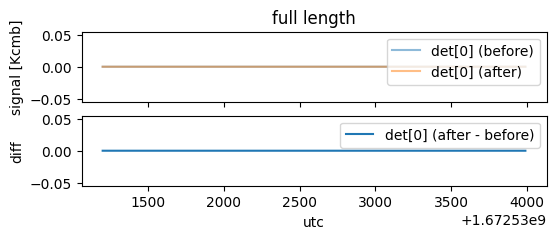

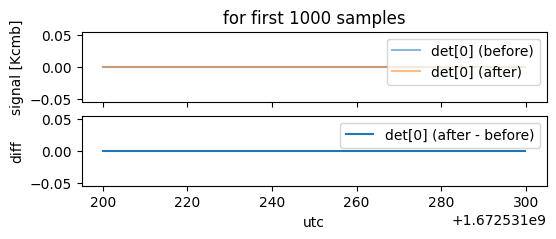

In [12]:
@decorater_for_comparison
def apply_noise_model(data):
    noise_model = toast.ops.DefaultNoiseModel(name='default_model', noise_model='noise_model')
    noise_model.apply(data)
    return data, noise_model

data_after_noise_model, noise_model = apply_noise_model(data)

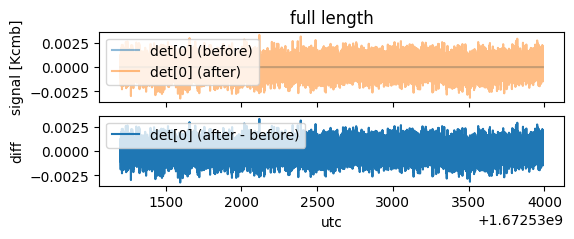

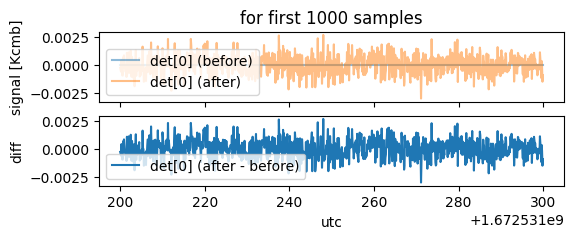

In [13]:
@decorater_for_comparison
def apply_sim_noise(data):
    sim_noise = toast.ops.SimNoise()
    sim_noise.apply(data)
    return data, sim_noise

data_after_sim_noise, sim_noise = apply_sim_noise(data)

# Elevation Noise model

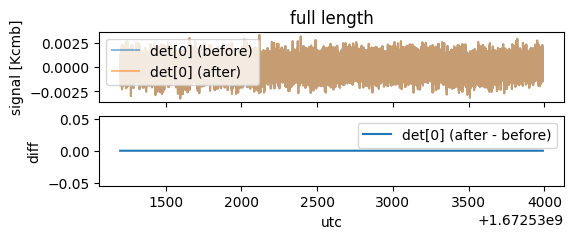

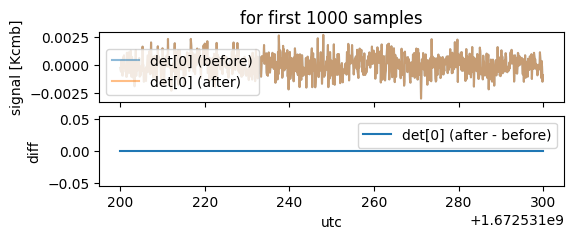

In [14]:
@decorater_for_comparison
def apply_elevation_model(data):
    elevation_model = toast.ops.ElevationNoise(name='default_model')
    elevation_model.detector_pointing = det_pointing_azel
    elevation_model.apply(data)
    return data, elevation_model

data, elevation_model = apply_elevation_model(data)

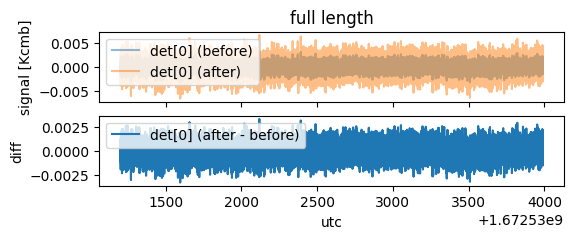

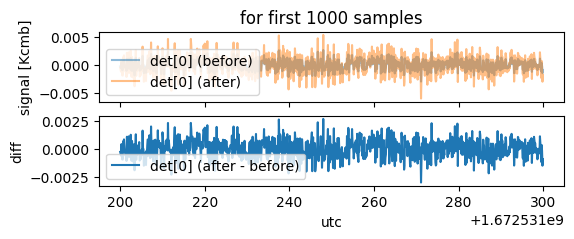

In [15]:
@decorater_for_comparison
def apply_sim_noise(data):
    sim_noise = toast.ops.SimNoise()
    sim_noise.apply(data)
    return data, sim_noise

data_after_sim_noise, sim_noise = apply_sim_noise(data)

# Stokes Weights Radec

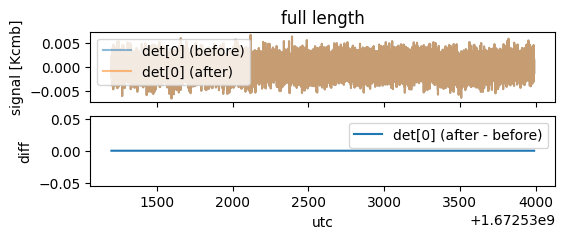

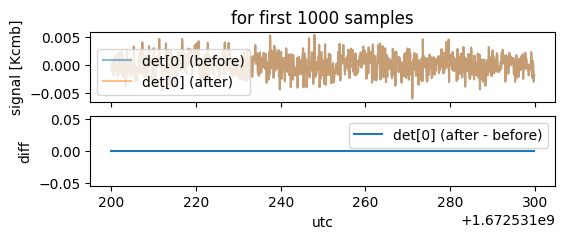

In [16]:
@decorater_for_comparison
def apply_weights_radec(data):
    weights_radec = toast.ops.stokes_weights.StokesWeights(
        mode = "IQU", # The Stokes weights to generate (I or IQU)
        name = "weights_radec", # The 'name' of this class instance,
        hwp_angle = "hwp_angle"
    )
    weights_radec.detector_pointing = det_pointing_radec
    weights_radec.apply(data)
    return data, weights_radec

data, weights_radec = apply_weights_radec(data)


# Stokes Weights Azel

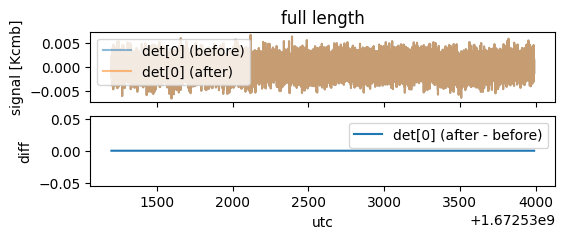

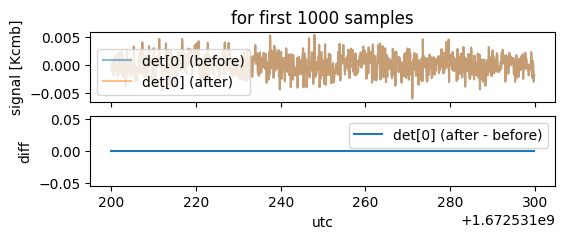

In [17]:
@decorater_for_comparison
def apply_weights_azel(data):
    weights_azel = toast.ops.stokes_weights.StokesWeights(
        mode = "IQU", # The Stokes weights to generate (I or IQU)
        name = "weights_azel", # The 'name' of this class instance,
        hwp_angle = "hwp_angle"
    )
    weights_azel.detector_pointing = det_pointing_azel
    weights_azel.apply(data)
    return data, weights_azel

data, weights_azel = apply_weights_azel(data)

# Atmosphere

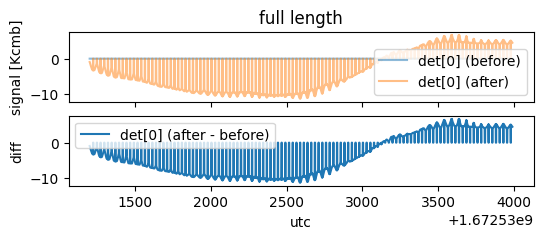

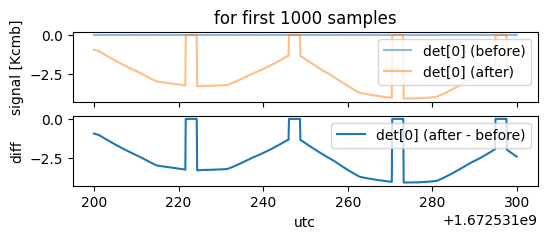

In [18]:
@decorater_for_comparison
def apply_sim_atmosphere_coarse(data):
    sim_atmosphere_coarse = toast.ops.SimAtmosphere(
                                                    name="sim_atmosphere_coarse",
                                                    add_loading=False,
                                                    lmin_center=300 * u.m,
                                                    lmin_sigma=30 * u.m,
                                                    lmax_center=10000 * u.m,
                                                    lmax_sigma=1000 * u.m,
                                                    xstep=50 * u.m,
                                                    ystep=50 * u.m,
                                                    zstep=50 * u.m,
                                                    zmax=2000 * u.m,
                                                    nelem_sim_max=30000,
                                                    gain=6e-4,
                                                    realization=1000000,
                                                    wind_dist=10000 * u.m,
                                                    enabled=True,
                                                )
    sim_atmosphere_coarse.detector_pointing = det_pointing_azel
    sim_atmosphere_coarse.apply(data)
    return data, sim_atmosphere_coarse
data, sim_atmosphere_coarse = apply_sim_atmosphere_coarse(data)

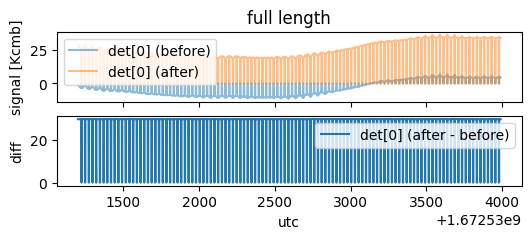

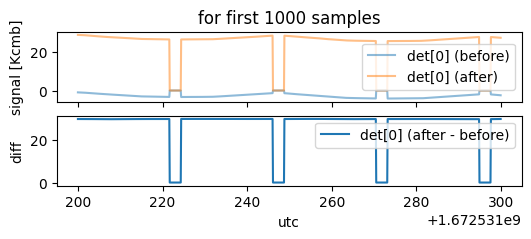

In [19]:
@decorater_for_comparison
def apply_sim_atmosphere(data):
    sim_atmosphere = toast.ops.SimAtmosphere(
                                            name="sim_atmosphere",
                                            add_loading=True,
                                            lmin_center=0.001 * u.m,
                                            lmin_sigma=0.0001 * u.m,
                                            lmax_center=1 * u.m,
                                            lmax_sigma=0.1 * u.m,
                                            xstep=5 * u.m,
                                            ystep=5 * u.m,
                                            zstep=5 * u.m,
                                            zmax=200 * u.m,
                                            gain=6e-5,
                                            wind_dist=3000 * u.m,
                                            enabled=True,
                                        )
    sim_atmosphere.detector_pointing = det_pointing_azel
    sim_atmosphere.apply(data)
    return data, sim_atmosphere
data, sim_atmosphere = apply_sim_atmosphere(data)

# Scan Synchronous Signal

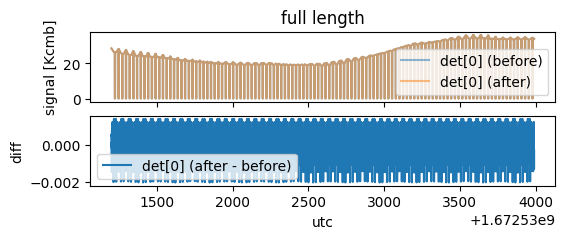

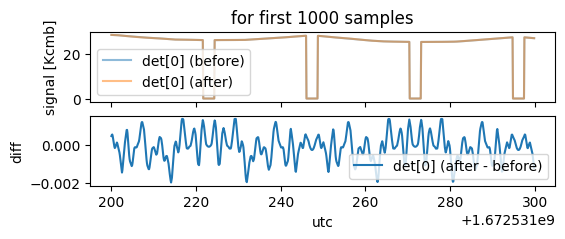

In [20]:
@decorater_for_comparison
def apply_scan_synchronous_signal(data):
    scan_synchronous_signal = toast.ops.SimScanSynchronousSignal(name='sim_sss')
    scan_synchronous_signal.detector_pointing = det_pointing_azel
    scan_synchronous_signal.apply(data)
    return data, scan_synchronous_signal

data, scan_synchronous_signal = apply_scan_synchronous_signal(data)

# Sim SSO

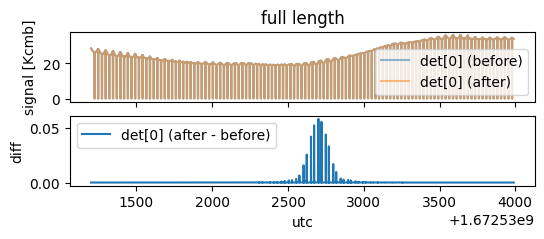

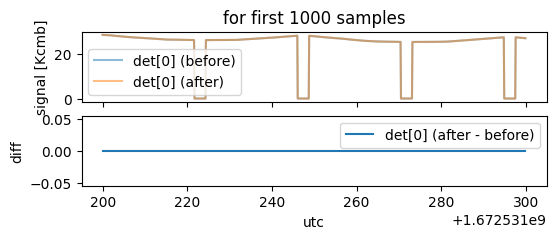

In [21]:
@decorater_for_comparison
def apply_sim_sso(data):
    sim_sso = so_ops.SimSSO(name='sim_sso')
    sim_sso.beam_file = '/homes/tterasaki/workspace/bcp/220910_manual_planet_sim/SAT_f090_beam.p'
    sim_sso.detector_pointing = det_pointing_azel
    sim_sso.sso_name = 'Jupiter'
    sim_sso.apply(data)
    return data, sim_sso
data, sim_sso = apply_sim_sso(data)

# HWPSS

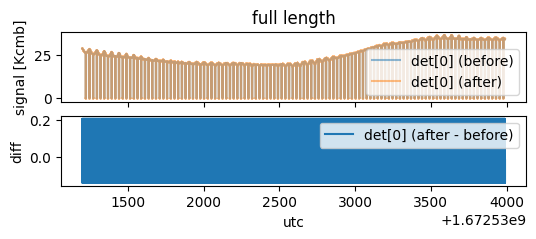

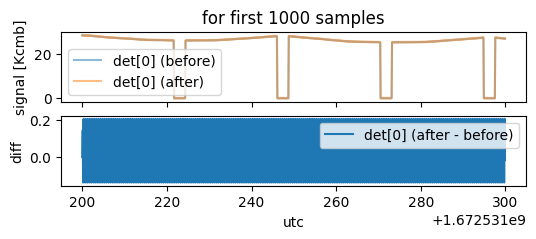

In [22]:
@decorater_for_comparison
def apply_sim_hwpss(data):
    sim_hwpss = so_ops.SimHWPSS(name='sim_hwpss')
    sim_hwpss.hwp_angle = sim_gnd.hwp_angle
    sim_hwpss.detector_pointing = det_pointing_azel
    sim_hwpss.stokes_weights = weights_azel
    sim_hwpss.apply(data)
    return data, sim_hwpss

data, sim_hwpss = apply_sim_hwpss(data)

# Time Constant

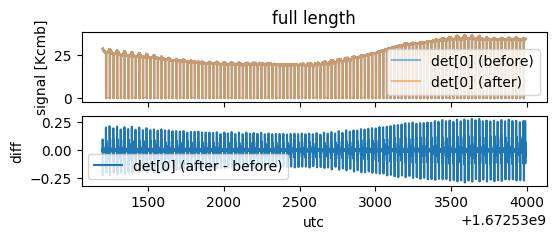

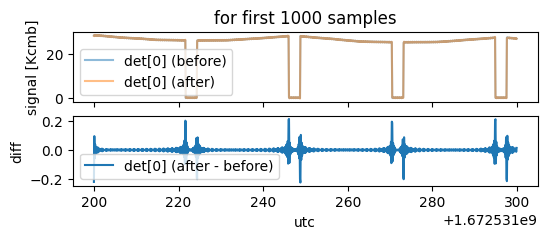

In [23]:
@decorater_for_comparison
def apply_conv_time_constant(data):
    conv_time_constant = toast.ops.TimeConstant(name='convolve_time_constant', deconvolve=False)
    conv_time_constant.tau = 1e-3 * u.s #1ms
    conv_time_constant.tau_sigma = 0.1 #10 percent
    conv_time_constant.realization = 1234
    conv_time_constant.apply(data)
    return data, conv_time_constant

data, conv_time_constant = apply_conv_time_constant(data)

# Gain Scrambler

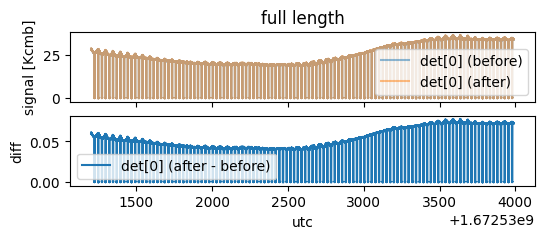

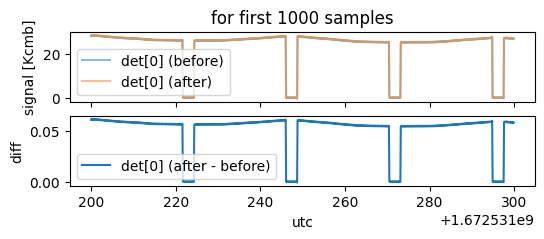

In [24]:
@decorater_for_comparison
def apply_gain_scrambler(data):
    gain_scrambler = toast.ops.GainScrambler(name="gainscrambler")
    gain_scrambler.center = 1 # Gain distribution center
    gain_scrambler.sigma = 0.001 # Gain distribution width
    gain_scrambler.apply(data)
    return data, gain_scrambler

data, gain_scrambler = apply_gain_scrambler(data)


# Load Fits file
get file from (https://pla.esac.esa.int/#maps)

In [25]:
IQUmap = hp.fitsfunc.read_map('/homes/tterasaki/workspace/bcp/220910_manual_planet_sim/HFI_SkyMap_100_2048_R3.01_full.fits', field=[0,1,2])
hp.fitsfunc.write_map('/homes/tterasaki/workspace/bcp/220910_manual_planet_sim/planck_100GHz_N2048_IQU.fits', IQUmap, overwrite=True)

setting the output map dtype to [dtype('float32'), dtype('float32'), dtype('float32')]


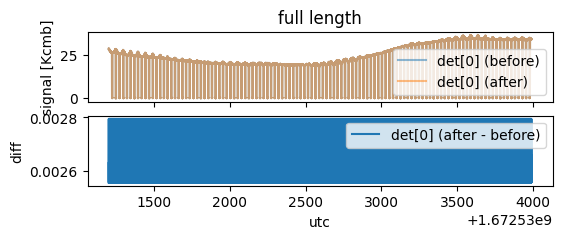

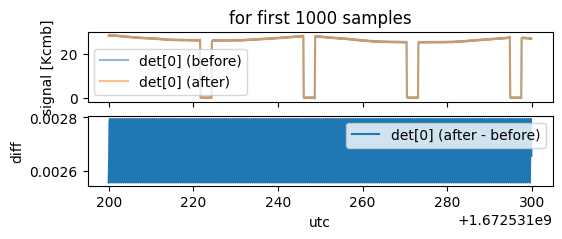

In [28]:
@decorater_for_comparison
def apply_scan_map(data):
    scan_map = toast.ops.ScanHealpixMap(name='scan_map',
                            file='/homes/tterasaki/workspace/bcp/220910_manual_planet_sim/planck_100GHz_N2048_IQU.fits')
    scan_map.pixel_pointing= pixels_radec
    scan_map.stokes_weights = weights_radec
    scan_map.apply(data)
    return data, scan_map

data, scan_map = apply_scan_map(data)


# Save HDF

In [27]:
save_hdf5 = toast.ops.SaveHDF5(name="save_hdf5")
hdf5_path = os.path.join('/homes/tterasaki/workspace/bcp/220910_manual_planet_sim', "data")
if not os.path.isdir(hdf5_path):
    os.makedirs(hdf5_path)
save_hdf5.volume = hdf5_path
save_hdf5.apply(data)